## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images


In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

%matplotlib inline 
#qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = ['./camera_cal/calibration%d.jpg'%(i+1) for i in range(len(os.listdir('./camera_cal')))]
example_to_show = [[] for _ in images]
# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    example_to_show[i].append(np.copy(img))
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        example_to_show[i].append(np.copy(img))

## show an example of chessboard

In [2]:
def show_campare(img1, img2):
    plt.figure(figsize=(16,12))
    plt.subplot(1,2,1)
    plt.imshow(img1)
    plt.title('original')
    plt.subplot(1,2,2)
    plt.title('output')
    if len(img2.shape) == 2:
        plt.imshow(img2, cmap='gray')
    else:
        plt.imshow(img2)
    plt.show()

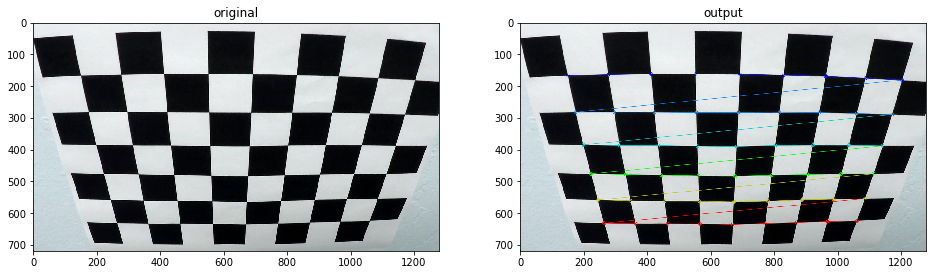

In [3]:

show_campare(example_to_show[1][0], example_to_show[1][1])

## get camera calibrate parameters

In [4]:
img_size = example_to_show[0][0].shape[::2]
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)

## show an example of calibrate

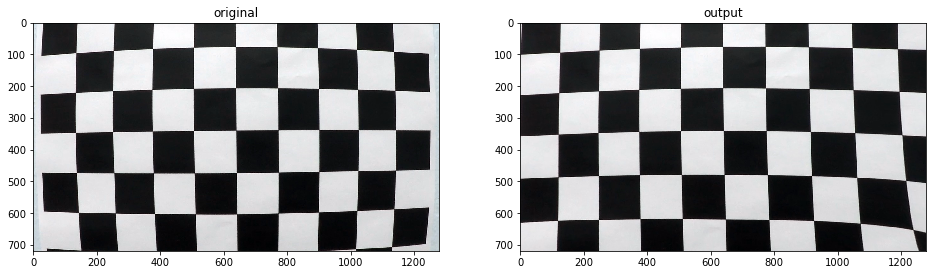

In [5]:
calibrate_example_dst = cv2.undistort(example_to_show[0][0], mtx, dist, None, mtx)
show_campare(example_to_show[0][0], calibrate_example_dst)

In [6]:
def UndistortImg(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

## show an example of undistort video sequence image

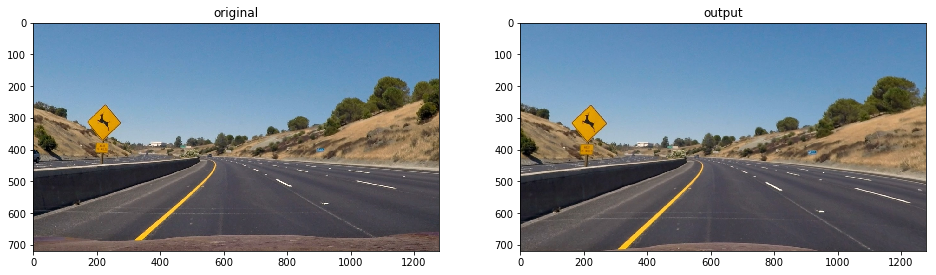

In [7]:
img = cv2.imread('./test_images/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistort_img = UndistortImg(img, mtx, dist)

show_campare(img, undistort_img)


## filter and segment image

In [8]:
# copy from my first project 
def color_threshold(img):
    s_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    l_channel = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:,:,0]
    b_channel = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:,:,2]   

    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= 175) & (s_channel <= 255)] = 1
    
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= 155) & (b_channel <= 200)] = 1
    
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= 210) & (l_channel <= 255)] = 1
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(s_binary == 1) | (b_binary == 1) | (l_binary == 1)] = 1

    return combined_binary

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255, ksize= 7):

    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize= ksize))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize= ksize))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output


def mag_thresh(gray, thresh_min=0, thresh_max = 255, ksize= 7):

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)

    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)

    binary_output = np.zeros_like(gradmag)

    binary_output[(gradmag >= thresh_min) & (gradmag <= thresh_max)] = 1

    return binary_output


def dir_threshold(gray, thresh_min=0, thresh_max=np.pi / 2, ksize=7):

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)

    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))

    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh_min) & (absgraddir <= thresh_max)] = 1

    return binary_output

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

args = {}

args['kernel_size'] = 5

In [9]:
def filter_img(img):
    # first extract hyper-parameters for pipeline from args
    kernel_size = args['kernel_size'] # kernel size for GaussianBlur    
    # convert RGB image to gray image
    img = gaussian_blur(img, kernel_size)
    
    color_masked = color_threshold(img)
    
    gray = grayscale(img)
    gradx = abs_sobel_thresh(gray, orient='x', thresh_min=10, thresh_max=255)
    grady = abs_sobel_thresh(gray, orient='y', thresh_min=60, thresh_max=255)
    mag_binary = mag_thresh(gray, thresh_min=60, thresh_max=255)
    dir_binary = dir_threshold(gray, thresh_min=.65, thresh_max= 1.05)

    # Combine all the thresholded images for the gradients
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    all_combined = np.zeros_like(combined)
    all_combined[(color_masked > 0) | (combined > 0)] = 1
    
    
    H, W, C = img.shape
    vertices = np.array([[(100, H), (610, 410), (680, 410), \
                          (W - 20, H), (1150, H), \
                          (700, 480), (650, 480), (310, H)]], dtype=np.int32)

    masked_edges = region_of_interest(all_combined, vertices)
    return masked_edges

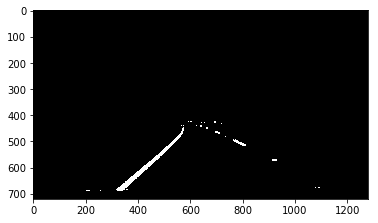

In [10]:
img = cv2.imread('./test_images/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

filtered_img = filter_img(img)
plt.imshow(filtered_img, cmap='gray')
plt.show()

## Perspective Transform

In [11]:

lanewidth=300
h=720
w=1280

# define src points through getting a plane in the image
src = np.float32([(585, 460),
                  (695, 460), 
                  (203, 720), 
                  (1127, 720)])

dst = np.float32([(320, 0),
                  (960, 0), 
                  (320, 720), 
                  (960, 720)])
# Defining the destinations points through offset and w/h of the given image
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

In [12]:
def get_perspective_img(img, M):
    h,w = img.shape[:2]
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped

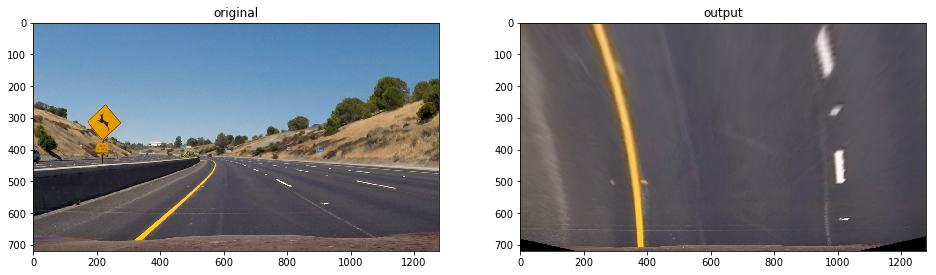

In [13]:
# Warp the image using OpenCV warpPerspective()
warped = get_perspective_img(img, M)
show_campare(img, warped)

# Lane Finder

In [14]:
a = np.array([0,1,2,3,0])
a.nonzero()

(array([1, 2, 3]),)

In [15]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit


def find_lane_pixels(binary_warped):
    # copy from udacity code
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

    return left_fit, right_fit, ploty, left_fitx, right_fitx

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    

    return left_fit, right_fit, ploty, left_fitx, right_fitx

In [16]:
ym_per_pix = 30./720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meteres per pixel in x dimension


class LaneFinder:
    def __init__(self):
        self.fit_left = None
        self.fit_right = None
        
    @staticmethod
    def compute_curvate_radius(left_fitx, right_fitx, y_vals):
        # Radian conversion
        fit_cr_left = np.polyfit(y_vals * ym_per_pix, left_fitx * xm_per_pix, 2)
        fit_cr_right = np.polyfit(y_vals * ym_per_pix, right_fitx * xm_per_pix, 2)
        
        left_curverad = ((1 + (2*fit_cr_left[0]*np.max(y_vals) + fit_cr_left[1])**2)**1.5)/np.absolute(2*fit_cr_left[0])
        right_curverad = ((1 + (2*fit_cr_right[0]*np.max(y_vals) + fit_cr_right[1])**2)**1.5)/np.absolute(2*fit_cr_right[0])
        
        # Half (right/left)
        return int((left_curverad + right_curverad)/2) 
    
    @staticmethod
    def draw(image, warped, yvals, left_fit, right_fit, left_fitx, right_fitx, Minv, curvature):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
        pts = np.hstack((pts_left, pts_right))
        # Draw the lane onto the warped blank image
        #print(color_warp.shape)
        #cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
        cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
        warp_back = get_perspective_img(color_warp, Minv)
        # Combine the result with the original image
        result = cv2.addWeighted(image, 1, warp_back, 0.3, 0)
        # Put text on an image
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(result,"Radius of Curvature: {} m".format(int(curvature)),(400,100), font, 1,(255,255,255),2)
        
        car_position = image.shape[1]/2

        rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
        leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
        
        lane_center = (rightx_int+leftx_int)/2
        distance = (car_position - lane_center) * xm_per_pix
        
        cv2.putText(result,"Distance to the center: {:.2f} m".format(distance),(400,150), font, 1,(255,255,255),2)
        return result
    
    @staticmethod
    def process_img(self, img):

        #show_campare(img, warped)
        return result, segment_img

In [17]:
class ProcessImage:
    
    def __init__(self, lanefinder):
        
        self.lane_finder = lanefinder
    def __call__(self, img):
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        undistort_img = UndistortImg(img, mtx, dist)
        segment_img = filter_img(undistort_img)
        
        input_img = get_perspective_img(segment_img, M)        
        
        if (self.lane_finder.fit_left is None) or (self.lane_finder.fit_right is None):
            left_fit, right_fit, ploty, left_fitx, right_fitx = find_lane_pixels(input_img)
        else:
            left_fit, right_fit, ploty, left_fitx, right_fitx = search_around_poly(
                input_img, self.lane_finder.fit_left, self.lane_finder.fit_right)
            self.fit_left = left_fit
            self.fit_right = right_fit
        
        curvature = self.lane_finder.compute_curvate_radius(left_fitx, right_fitx,ploty)
        
        result = self.lane_finder.draw(img, input_img , ploty, left_fit, right_fit, left_fitx, right_fitx, Minv, curvature)
        result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
        return result


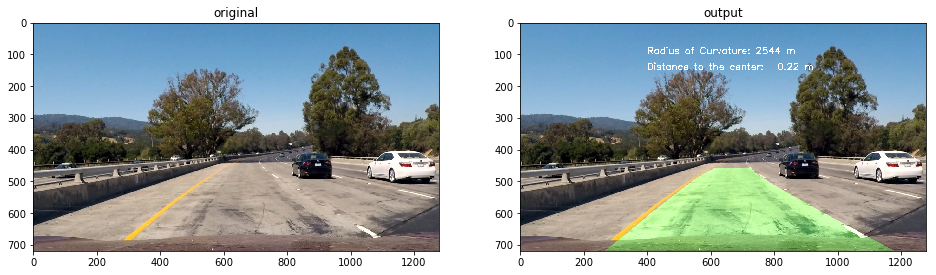

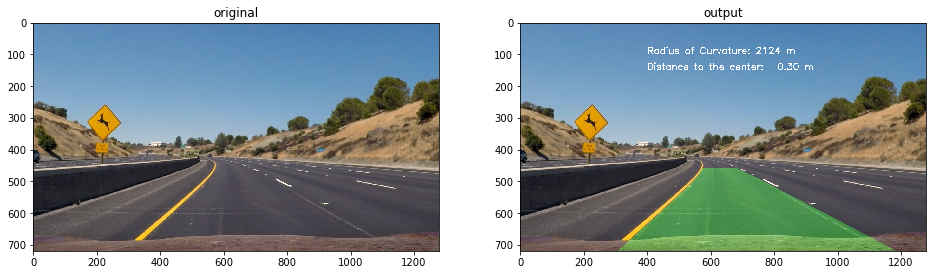

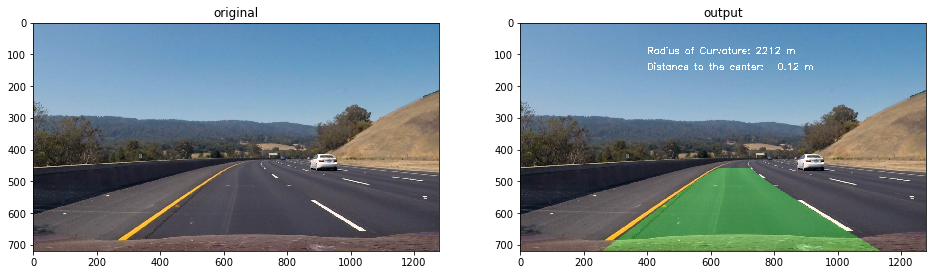

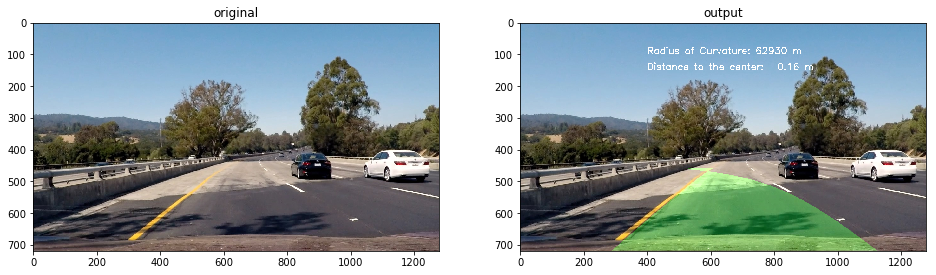

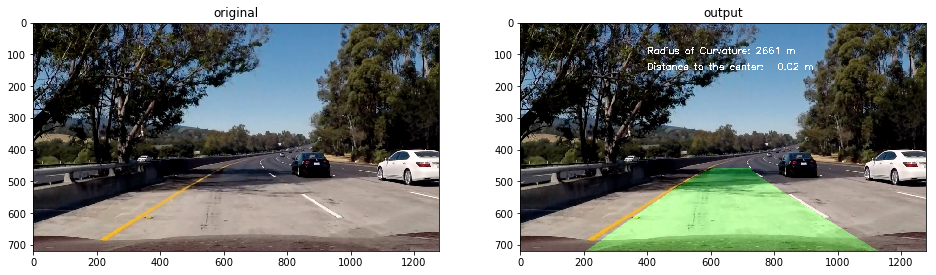

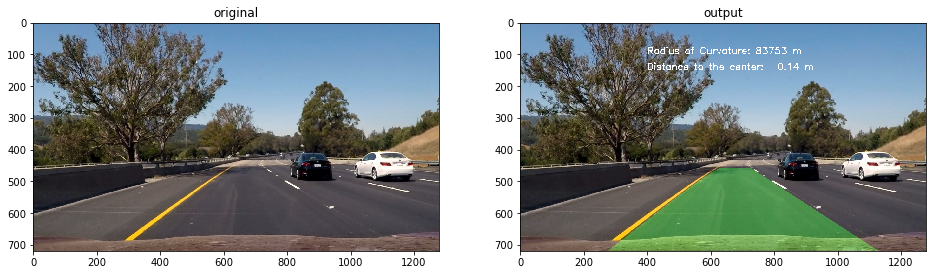

In [18]:
lane_finder=LaneFinder()
process_obj = ProcessImage(lane_finder)
test_image_name = ['./test_images/test%d.jpg'%(i+1) for i in range(6)]

for img_name in test_image_name:
    
    img = cv2.imread(img_name)
    
    processed_img= process_obj(img)
    show_campare(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))

In [19]:
## Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# Set up lines for left and right
lane_finder=LaneFinder()
output = 'output.mp4'
video_input = VideoFileClip('./project_video.mp4', audio=False)

processed_video = video_input.fl_image(ProcessImage(lane_finder))
video_output = 'output.mp4'
processed_video.write_videofile(video_output, audio=False)

video_input.reader.close()#print(clip1)


pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output.mp4.
Moviepy - Writing video output.mp4



Moviepy - Done !
Moviepy - video ready output.mp4
